# Ensemble Volatility

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import timeit

import warnings
warnings.filterwarnings("ignore")

In [2]:
import logging
logging.basicConfig(filename='app.log', filemode='w', format='%(asctime)s — %(name)s — %(levelname)s — %(funcName)s:%(lineno)d — %(message)s', datefmt='%d-%b-%y %H:%M:%S')

logging.debug('This is a debug message')
logging.info('This is an info message')
logging.warning('This is a warning message')
logging.error('This is an error message')
logging.critical('This is a critical message')

# List of Stocks and ETFs
Provided by Thomas Choi.

In [3]:
stock_list = pd.read_csv("../stocks_and_etfs/stock_list.csv")
etf_list = pd.read_csv("../stocks_and_etfs/etf_list.csv")

In [4]:
import random

# Choose a random stock
# stock_symbol = random.choice(stock_list.iloc[:,0])
stock_symbol = "AMAT"
print(stock_symbol)

AMAT


## MySQL connection
Choosing one stock from SQL query to reduce query time.

In [5]:
import os
import sys
import mysql.connector

HOST="143.244.188.157"
PORT="3306"
USER="patrick-finProj"
PASSWORD="Pat#21$rick"

try: 
    conn = mysql.connector.connect(
        host=HOST,
        port=PORT,
        user=USER,
        password=PASSWORD,
        database="GlobalMarketData"
    )
    query = f"SELECT Date, Close, Open, High, Low, Volume from histdailyprice3 WHERE Symbol='{stock_symbol}';"
    histdailyprice3 = pd.read_sql(query, conn)
    conn.close()
except Exception as e:
    conn.close()
    print(str(e))

# Data

In [6]:
df = histdailyprice3.copy()
df

,Date,Close,Open,High,Low,Volume
0,1998-01-01,7.5313,7.5313,7.5313,7.5313,0
1,1998-01-02,7.5625,7.7657,7.5000,7.7500,17008800
2,1998-01-05,7.8594,8.3125,7.7500,8.2813,51539600
3,1998-01-06,8.1250,8.2188,7.7500,7.8125,38069200
4,1998-01-07,7.6563,7.6719,7.3125,7.3750,34373600
...,...,...,...,...,...,...
6142,2021-08-30,137.5700,137.8900,135.3800,136.0500,4617600
6143,2021-08-31,136.4500,136.6000,133.5500,135.1300,5586000
6144,2021-09-01,135.6800,136.0400,133.2400,133.4600,6260200
6145,2021-09-02,134.7300,135.9500,133.8800,134.4500,5146500


In [7]:
returns = 100 * df['Close'].pct_change().dropna()
realized_vol = returns.rolling(5).std()

In [8]:
n = int(len(returns)*0.4)
split_date = returns[-n:].index

# ARCH

In [9]:
from arch import arch_model
model = arch_model(returns, mean='Zero', vol='ARCH', p=1, o=0, q=0)
model_fitted = model.fit(disp='off')
print(model_fitted.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -14792.5
Distribution:                  Normal   AIC:                           29589.1
Method:            Maximum Likelihood   BIC:                           29602.5
                                        No. Observations:                 6146
Date:                Sat, Feb 26 2022   Df Residuals:                     6146
Time:                        13:03:25   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          5.3244      0.284     18.736  2.506e-78 [  4.767,  5.88

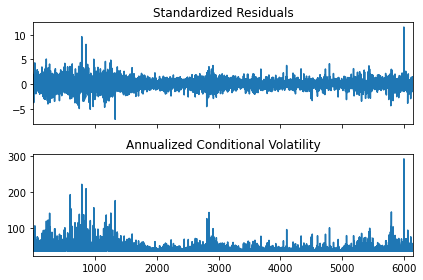

In [10]:
model_fitted.plot(annualize='D')

plt.tight_layout()
plt.show()

In [11]:
model = arch_model(returns, mean='Zero', vol='ARCH', p=1, o=0, q=0)
model_fit = model.fit(disp='off')
pred = model_fit.forecast(horizon=1)

In [12]:
bic_arch = []

for p in range(1, 5):
    arch = arch_model(returns, mean='zero', vol='ARCH', p=p).fit(disp='off')
    bic_arch.append(arch.bic)
    if arch.bic == np.min(bic_arch):
         best_param = p
arch = arch_model(returns, mean='zero', vol='ARCH', p=best_param).fit(disp='off')
print(arch.summary())
forecast = arch.forecast(start=split_date[0])
forecast_arch = forecast

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -14480.3
Distribution:                  Normal   AIC:                           28970.6
Method:            Maximum Likelihood   BIC:                           29004.2
                                        No. Observations:                 6146
Date:                Sat, Feb 26 2022   Df Residuals:                     6146
Time:                        13:04:30   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          2.8176      0.283      9.941  2.765e-23   [  2.26

In [13]:
from sklearn.metrics import mean_squared_error as mse

forecast_arch.variance

,h.1
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
...,...
6142,5.724526
6143,5.044322
6144,5.234462
6145,4.772874


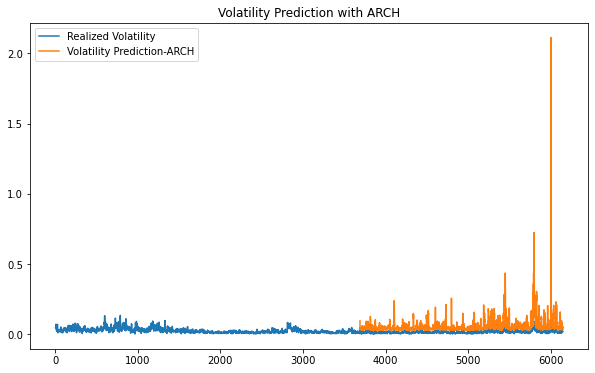

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()

In [15]:
rmse_arch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_arch.variance.iloc[-len(split_date):].fillna(0) / 100)))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model is 0.2278


# GARCH

In [16]:
garch = arch_model(returns, mean='zero', vol='GARCH', p=1, o=0, q=1).fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -14106.7
Distribution:                  Normal   AIC:                           28219.4
Method:            Maximum Likelihood   BIC:                           28239.6
                                        No. Observations:                 6146
Date:                Sat, Feb 26 2022   Df Residuals:                     6146
Time:                        13:04:31   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0290  1.338e-02      2.168  3.019e-02 [2.

In [17]:
def best_GARCH():
    bic_garch = []
    for p in range(1, 5):
        for q in range(1, 5):
            garch = arch_model(returns, mean='zero', vol='GARCH', p=p, o=0, q=q).fit(disp='off')
            bic_garch.append(garch.bic)
            if garch.bic == np.min(bic_garch):
                best_param = p, q
    garch = arch_model(returns, mean='zero', vol='GARCH',
                    p=best_param[0], o=0, q=best_param[1]).fit(disp='off')
    return garch
garch = best_GARCH()
print(garch.summary())
forecast = garch.forecast(start=split_date[0])
forecast_garch = forecast

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -14097.7
Distribution:                  Normal   AIC:                           28203.3
Method:            Maximum Likelihood   BIC:                           28230.2
                                        No. Observations:                 6146
Date:                Sat, Feb 26 2022   Df Residuals:                     6146
Time:                        13:04:33   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0487  2.069e-02      2.353  1.863e-02 [8.

In [18]:
forecast_garch.variance / 100

,h.1
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
...,...
6142,0.055089
6143,0.045389
6144,0.050181
6145,0.043877


In [19]:
n = int(len(returns)*0.1)
split_date = returns[-n:].index
split_date

Int64Index([5533, 5534, 5535, 5536, 5537, 5538, 5539, 5540, 5541, 5542,
            ...
            6137, 6138, 6139, 6140, 6141, 6142, 6143, 6144, 6145, 6146],
           dtype='int64', length=614)

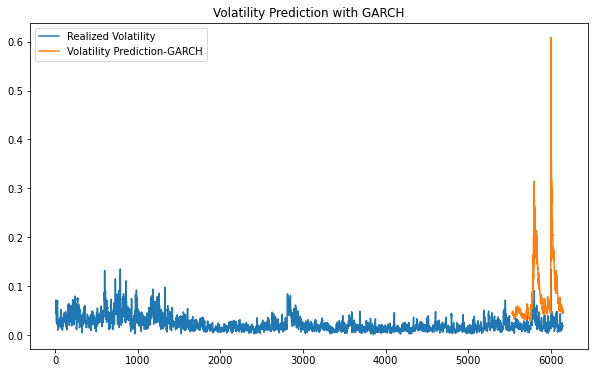

In [20]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()
plt.show()

In [21]:
rmse_garch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_garch.variance.iloc[-len(split_date):].fillna(0) / 100)))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))

The RMSE value of GARCH model is 0.2598


# GJR GARCH

In [22]:
def best_GJR_GARCH():
    bic_gjr_garch = []
    for p in range(1, 5):
        for q in range(1, 5):
            gjrgarch = arch_model(returns, mean='zero', p=p, o=1, q=q).fit(disp='off')
            bic_gjr_garch.append(gjrgarch.bic)
            if gjrgarch.bic == np.min(bic_gjr_garch):
                 best_param = p, q
    gjrgarch = arch_model(returns, mean='zero', p=best_param[0], o=1, q=best_param[1]).fit(disp='off')
    return gjrgarch
gjrgarch = best_GJR_GARCH()
print(gjrgarch.summary())
forecast = gjrgarch.forecast(start=split_date[0])
forecast_gjrgarch = forecast

                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -14077.6
Distribution:                  Normal   AIC:                           28165.2
Method:            Maximum Likelihood   BIC:                           28198.8
                                        No. Observations:                 6146
Date:                Sat, Feb 26 2022   Df Residuals:                     6146
Time:                        13:04:35   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0524  2.145e-02      2.443  1.457e-02 [1.

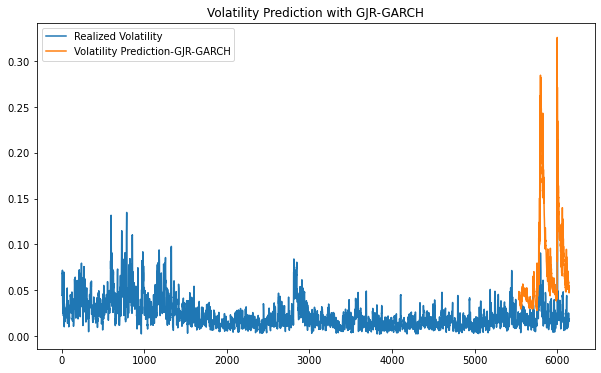

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_gjrgarch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-GJR-GARCH')
plt.title('Volatility Prediction with GJR-GARCH', fontsize=12)
plt.legend()
plt.show()

In [24]:
rmse_gjr_garch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_gjrgarch.variance.iloc[-len(split_date):].fillna(0) / 100)))
print('The RMSE value of GJR-GARCH models is {:.4f}'.format(rmse_gjr_garch))

The RMSE value of GJR-GARCH models is 0.2480


# EGARCH

In [25]:
def best_EGARCH():
    bic_egarch = []

    for p in range(1, 5):
        for q in range(1, 5):
            egarch = arch_model(returns, mean='zero', vol='EGARCH', p=p, q=q).fit(disp='off')
            bic_egarch.append(egarch.bic)
            if egarch.bic == np.min(bic_egarch):
                best_param = p, q
    egarch = arch_model(returns, mean='zero', vol='EGARCH', p=best_param[0], q=best_param[1]).fit(disp='off')
    return egarch
egarch = best_EGARCH()
print(egarch.summary())
forecast = egarch.forecast(start=split_date[0])
forecast_egarch = forecast

                       Zero Mean - EGARCH Model Results                       
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -14080.0
Distribution:                  Normal   AIC:                           28168.0
Method:            Maximum Likelihood   BIC:                           28194.9
                                        No. Observations:                 6146
Date:                Sat, Feb 26 2022   Df Residuals:                     6146
Time:                        13:04:37   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0118  3.446e-03      3.414  6.398e-04 [5.

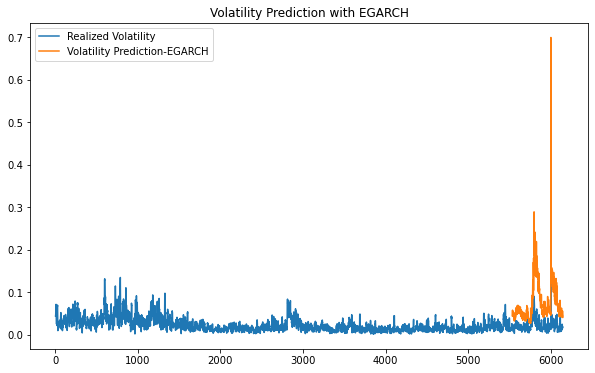

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_egarch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-EGARCH')
plt.title('Volatility Prediction with EGARCH', fontsize=12)
plt.legend()
plt.show()

In [27]:
rmse_egarch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_egarch.variance.iloc[-len(split_date):].fillna(0) / 100)))
print('The RMSE value of EGARCH models is {:.4f}'.format(rmse_egarch))

The RMSE value of EGARCH models is 0.2474


# SVR GARCH

In [28]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

In [39]:
# Compute realized volatility
def realized_volatilty():
    realized_vol = returns.rolling(5).std()
    realized_vol = pd.DataFrame(realized_vol)
    realized_vol.reset_index(drop=True, inplace=True)

    returns_svm = returns ** 2
    returns_svm = returns_svm.reset_index()
    del returns_svm['index']

    X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
    X = X[4:].copy()
    X = X.reset_index()
    X.drop('index', axis=1, inplace=True)

    realized_vol = realized_vol.dropna().reset_index()
    realized_vol.drop('index', axis=1, inplace=True)
    return X, realized_vol

X, realized_vol = realized_volatilty()
    
#svr_poly = SVR(kernel='poly', degree=2)
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

In [40]:
X.iloc[:-n].values

array([[ 4.44848468, 20.16386867],
       [ 4.47558755,  0.73051355],
       [ 5.0055659 , 79.16776834],
       ...,
       [ 2.33296282,  0.37986614],
       [ 1.39274819,  2.82101102],
       [ 1.29173126,  7.25641742]])

In [42]:
realized_vol.iloc[1:-(n-1)].values.reshape(-1,)

array([4.47558755, 5.0055659 , 6.77696961, ..., 1.39274819, 1.29173126,
       1.42617247])

In [59]:
realized_vol = returns.rolling(5).std()
returns_svm = returns ** 2
X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
X = X[4:].copy()
X = X.reset_index(drop=True)
#X.drop('index', axis=1, inplace=True)
X

,0,1
0,4.448485,20.163869
1,4.475588,0.730514
2,5.005566,79.167768
3,6.776970,70.090898
4,6.866027,18.419685
...,...,...
6137,1.590668,11.753335
6138,1.649057,0.662809
6139,1.706518,0.318445
6140,1.788224,0.490248


## Linear

In [58]:
start = timeit.default_timer()

para_grid = {'gamma': sp_rand(), 'C': sp_rand(), 'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_lin, para_grid, n_jobs=8)
clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_lin = clf.predict(X.iloc[-n:])

predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = returns.iloc[-n:].index

rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_lin / 100))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'.format(rmse_svr))

stop = timeit.default_timer()
print('Time: ', stop - start)

ValueError: Found input variables with inconsistent numbers of samples: [5528, 5532]

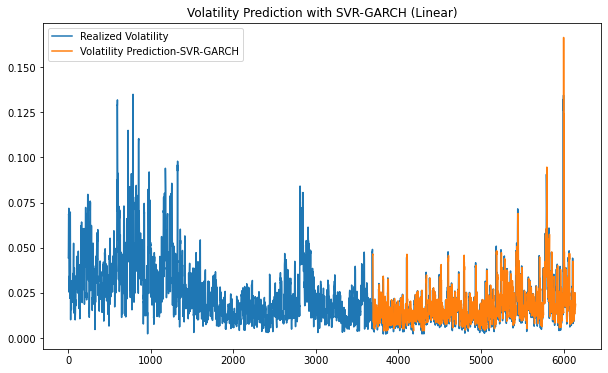

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_lin / 100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()

In [29]:
rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_lin / 100))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'.format(rmse_svr))

The RMSE value of SVR with Linear Kernel is 0.001256


## Radial basis function

In [30]:
start = timeit.default_timer()

para_grid ={'gamma': sp_rand(), 'C': sp_rand(), 'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_rbf, para_grid, n_jobs=8)
clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_rbf = clf.predict(X.iloc[-n:])

predict_svr_rbf = pd.DataFrame(predict_svr_rbf)
predict_svr_rbf.index = returns.iloc[-n:].index

stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  4.432840200000001


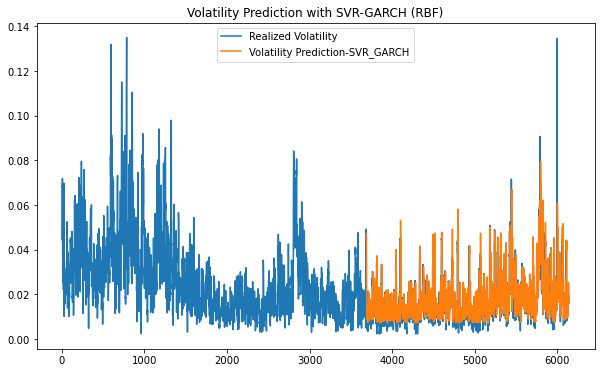

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(predict_svr_rbf / 100, label='Volatility Prediction-SVR_GARCH')
plt.title('Volatility Prediction with SVR-GARCH (RBF)', fontsize=12)
plt.legend()
plt.show()

In [32]:
rmse_svr_rbf = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_rbf / 100))
print('The RMSE value of SVR with RBF Kernel is  {:.6f}'.format(rmse_svr_rbf))

The RMSE value of SVR with RBF Kernel is  0.003946


## Polynomial Kernal
Long run time 

In [33]:
#start = timeit.default_timer()

#para_grid = {'gamma': sp_rand(), 'C': sp_rand(), 'epsilon': sp_rand()}
#clf = RandomizedSearchCV(svr_poly, para_grid, n_jobs=8)
#clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
#predict_svr_poly = clf.predict(X.iloc[-n:])

#predict_svr_poly = pd.DataFrame(predict_svr_poly)
#predict_svr_poly.index = returns.iloc[-n:].index

#stop = timeit.default_timer()
#print('Time: ', stop - start)

In [34]:
#plt.figure(figsize=(10, 6))
#plt.plot(realized_vol/100, label='Realized Volatility')
#plt.plot(predict_svr_poly/100, label='Volatility Prediction-SVR-GARCH')
#plt.title('Volatility Prediction with SVR-GARCH (Polynomial)', fontsize=12)
#plt.legend()
#plt.show()

In [35]:
#rmse_svr_poly = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_poly / 100))
#print('The RMSE value of SVR with Polynomial Kernel is {:.6f}'.format(rmse_svr_poly))

# Neural Networks

In [36]:
from sklearn.neural_network import MLPRegressor
NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1)
para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
                'max_iter': [500, 1000],
                'alpha': [0.00005, 0.0005 ]}
clf = RandomizedSearchCV(NN_vol, para_grid_NN, n_jobs=8)
clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1, ))
NN_predictions = clf.predict(X.iloc[-n:])
NN_predictions = pd.DataFrame(NN_predictions)
NN_predictions.index = returns.iloc[-n:].index

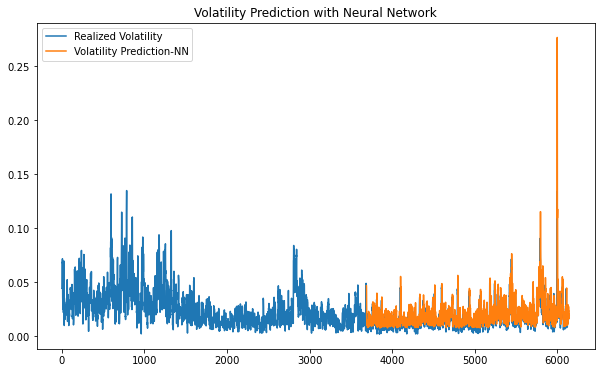

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(NN_predictions / 100, label='Volatility Prediction-NN')
plt.title('Volatility Prediction with Neural Network', fontsize=12)
plt.legend()
plt.show()

In [38]:
rmse_NN = np.sqrt(mse(realized_vol.iloc[-n:] / 100, NN_predictions / 100))
print('The RMSE value of NN is {:.6f}'.format(rmse_NN))

The RMSE value of NN is 0.004056


## TensorFlow

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error as mse

In [45]:
model = keras.Sequential([layers.Dense(256, activation="relu"),
                          layers.Dense(128, activation="relu"),
                          layers.Dense(1, activation="linear"),])

model.compile(loss='mse', optimizer='rmsprop')
epochs_trial = np.arange(100, 400, 4)
batch_trial = np.arange(100, 400, 4)
DL_pred = []
DL_RMSE = []
for i, j, k in zip(range(4), epochs_trial, batch_trial):
    model.fit(X.iloc[:-n].values,
              realized_vol.iloc[1:-(n-1)].values.reshape(-1,),
              batch_size=k, epochs=j, verbose=False)
    DL_predict = model.predict(np.asarray(X.iloc[-n:]))
    DL_RMSE.append(np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                         DL_predict.flatten() / 100)))
    DL_pred.append(DL_predict)
    print('DL_RMSE_{}:{:.6f}'.format(i+1, DL_RMSE[i]))

DL_RMSE_1:0.003254
DL_RMSE_2:0.001942
DL_RMSE_3:0.002888
DL_RMSE_4:0.002490


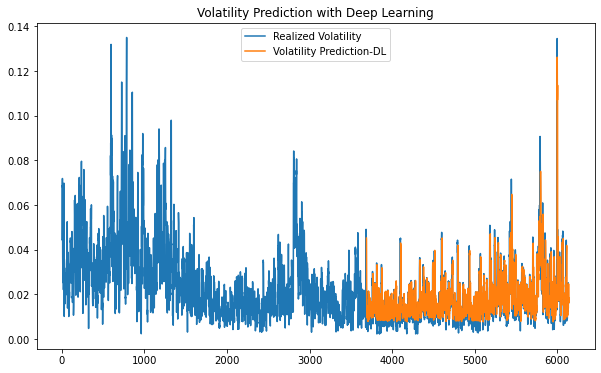

In [46]:
DL_predict = pd.DataFrame(DL_pred[DL_RMSE.index(min(DL_RMSE))])
DL_predict.index = returns.iloc[-n:].index

plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100,label='Realized Volatility')
plt.plot(DL_predict / 100,label='Volatility Prediction-DL')
plt.title('Volatility Prediction with Deep Learning',  fontsize=12)
plt.legend()
plt.show()

# Bayesian Approach

In [47]:
#from scipy.stats import kurtosis
#import pyflux as pf

In [48]:
#model = pf.GARCH(returns.values, p=1, q=1)
#print(model.latent_variables)
#model.adjust_prior(1, pf.Normal())
#model.adjust_prior(2, pf.Normal())
#x = model.fit(method='M-H', iterations='1000')
#print(x.summary())

#model.plot_z([1, 2])
#model.plot_fit(figsize=(15, 5))
#model.plot_ppc(T=kurtosis, nsims=1000)

In [49]:
#start = timeit.default_timer()

#bayesian_prediction = model.predict_is(n, fit_method='M-H')
#bayesian_RMSE = np.sqrt(mse(realized_vol.iloc[-n:] / 100, bayesian_prediction.values / 100))
#bayesian_prediction.index = returns.iloc[-n:].index

#stop = timeit.default_timer()
#print('Time: ', stop - start)

In [50]:
#plt.figure(figsize=(10, 6))
#plt.plot(realized_vol / 100, label='Realized Volatility')
#plt.plot(bayesian_prediction['Series'] / 100, label='Volatility Prediction-Bayesian')
#plt.title('Volatility Prediction with M-H Approach', fontsize=12)
#plt.legend()
#plt.show()

# RSME

In [51]:
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))
print('The RMSE value of GJR-GARCH models is {:.4f}'.format(rmse_gjr_garch))
print('The RMSE value of EGARCH models is {:.4f}'.format(rmse_egarch))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'.format(rmse_svr))
print('The RMSE value of SVR with RBF Kernel is  {:.6f}'.format(rmse_svr_rbf))
#print('The RMSE value of SVR with Polynomial Kernel is {:.6f}'.format(rmse_svr_poly))
print('The RMSE value of NN is {:.6f}'.format(rmse_NN))
print('The RMSE value of DL_RMSE is', DL_RMSE)
#print('The RMSE value of Bayesian_RMSE is {:.6f}'.format(bayesian_RMSE))

The RMSE value of ARCH model is 0.2278
The RMSE value of GARCH model is 0.2011
The RMSE value of GJR-GARCH models is 0.1974
The RMSE value of EGARCH models is 0.1944
The RMSE value of SVR with Linear Kernel is 0.001256
The RMSE value of SVR with RBF Kernel is  0.003946
The RMSE value of NN is 0.004056
The RMSE value of DL_RMSE is [0.0032543674245129784, 0.00194216181465403, 0.002887748263635897, 0.002490108185856602]
